# Random walks and switchpoint detection
In this notebook we begin with a brief introduction of _random walks_, followed by a toy model for financial portfolio value.

After modeling the portfolio value directly, we improve the model by modeling the underlying _interest rate_, resulting in a model structure very similar to our $\mu(t)$ method for growth rate estimation.

Finally, we illustrate how automatic switchpoint detection may be implemented with a Stundent-t random walk model.

In [1]:
import numpy
from matplotlib import cm, patches, pyplot
import pathlib
import pymc3
import scipy.stats
import theano.tensor as tt
from IPython.display import display

import bletl.growth

DP_RESULTS = pathlib.Path("..", "results")

numpy.random.seed(20210730)

## Step 1: What is a _random walk_?
A random walk is an iterative drift of a variable such that in each step the drive is drawn from a probability distribution.
We can simulate a random walk by iteratively drawing a drift $\Delta$ from, for example, Normal distribution and adding it to our previous value.

-2.219033475173588
-4.645081714115033
-6.7491058732949485
1.1320880159226996
-3.1799159638015113
3.3747962344052977
3.456027995264635
-0.8203536269327976
3.1210840906670114


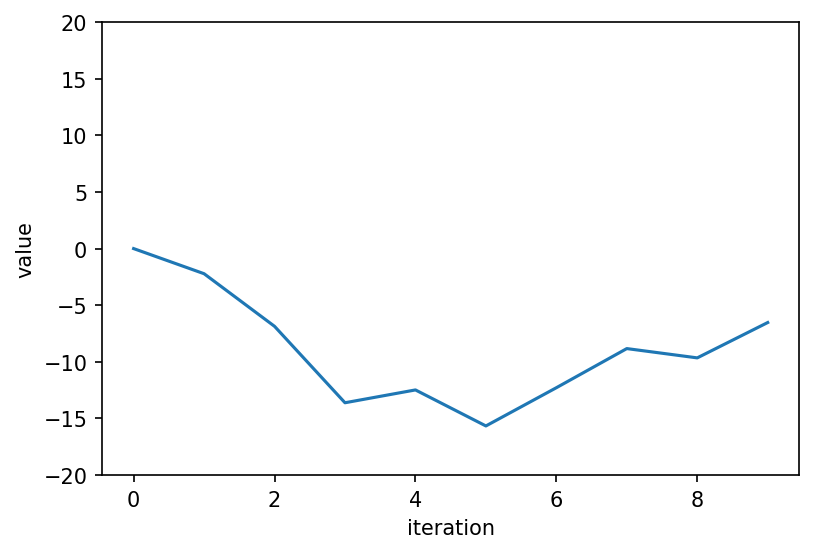

In [2]:
T = 10
years = numpy.arange(T)

values = [0]
for t in range(T-1):
    delta = numpy.random.normal(loc=0, scale=5)
    print(delta)
    values.append(values[-1] + delta)

fig, ax = pyplot.subplots(dpi=150)
ax.plot(years, values)
ax.set(
    xlabel="iteration",
    ylabel="value",
    ylim=(-20, 20),
)
pyplot.show()

### Condensing the implementation
Instead of the `for` loop from above, we can use a cumulative sum (`cumsum`) to implement the random walk in one line.

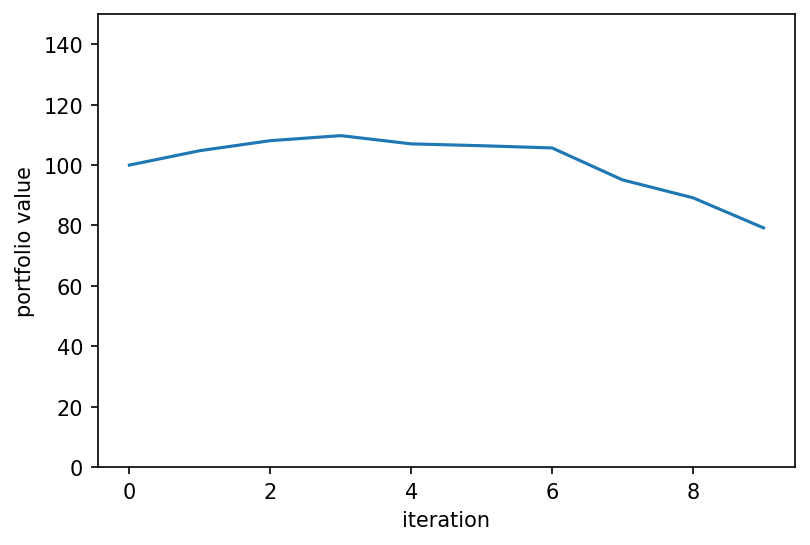

In [3]:
years = numpy.arange(T)

values = 100 + numpy.hstack(([0], numpy.cumsum(
    numpy.random.normal(loc=0, scale=5, size=T-1)
)))

fig, ax = pyplot.subplots(dpi=150)
ax.plot(years, values)
ax.set(
    xlabel="iteration",
    ylabel="portfolio value",
    ylim=(0, 150),
)
pyplot.show()

### _Distribution_ of random walks
Each random walk is a stochastic process, so if we repeat that many times we'll get a distribution of possible outcomes.

Notice how our "uncertainty" grows the further into the future we simulate.

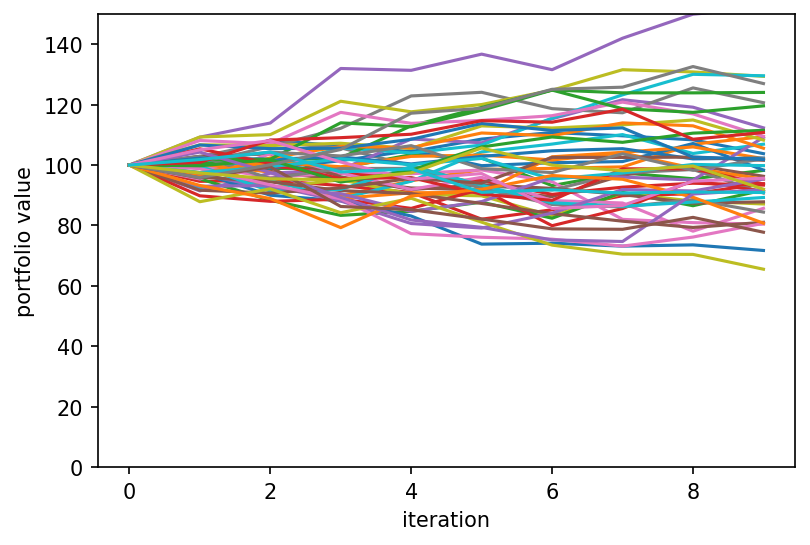

In [4]:
fig, ax = pyplot.subplots(dpi=150)

for i in range(50):
    values = 100 + numpy.hstack(([0], numpy.cumsum(
        numpy.random.normal(loc=0, scale=5, size=T-1)
    )))
    ax.plot(years, values)
    
ax.set(
    xlabel="iteration",
    ylabel="portfolio value",
    ylim=(0, 150),
)
pyplot.show()

## Step 2 - Application Example
Let's say we have a dataset of portfolio value over time and want to predict how it's going to develop in the next 5 years.

Our dataset comprises just the portfolio value at the end of the year:

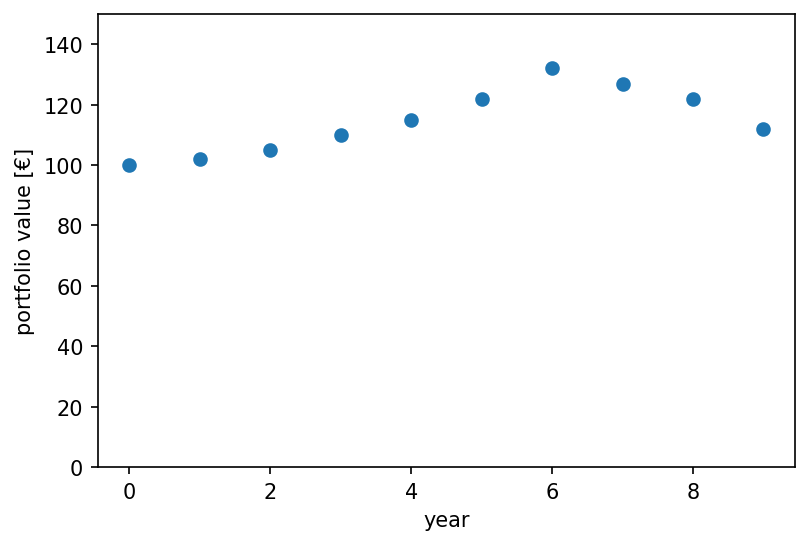

In [5]:
years = numpy.arange(T)
values = [100, 102, 105, 110, 115, 122, 132, 127, 122, 112]

fig, ax = pyplot.subplots(dpi=150)

ax.scatter(years, values)
ax.set(
    ylim=(0, 150),
    ylabel="portfolio value [€]",
    xlabel="year",
)
pyplot.show()

We can use the probabilistic programming library [PyMC3](https://github.com/pymc-devs/pymc3) to model the portfolio value as a random walk.
The model needs a so-called likelihood function that tells it how exact the observations are.
Here the precision of the observation is assumed to be normally distributed with a standard deviation of 2 €.

Our model will already describe the portfolio value for `T_predict` years into the future, but obviously the first `[:T]` years with data were observed.

In [6]:
T_predict = 5

with pymc3.Model() as pmodel:
    # model portfolio values over time
    t_values = pymc3.GaussianRandomWalk("values", sd=3, shape=T + T_predict)
    
    # "measurements" are inaccurate with σ = 2 €
    pymc3.Normal("likelihood", mu=t_values[:T], sd=2, observed=values)

Now we can "hit the inference button™" and run Markov-chain Monte Carlo sampling to draw samples from the posterior probability distribution about the portfolio value.

In [7]:
with pmodel:
    idata_A = pymc3.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [values]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 27 seconds.


If we draw the posterior probability density over time, we can see how the model is very certain about the portfolio value in the past, but the further we predict into the future, the more uncertainty we have.

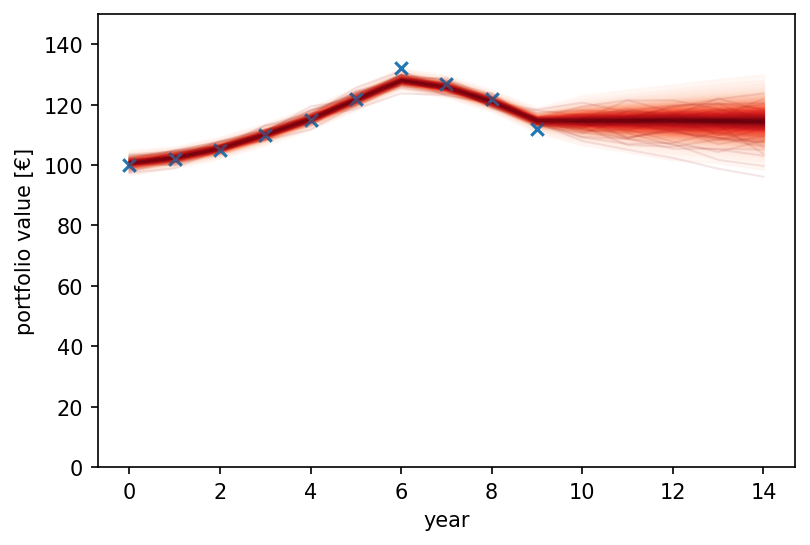

In [8]:
posterior = idata_A.posterior.stack(sample=("chain", "draw"))

fig, ax = pyplot.subplots(dpi=150)

pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=numpy.arange(T+T_predict),
    samples=posterior["values"].values.T,
)
ax.scatter(years, values, marker="x")

ax.set(
    ylim=(0, 150),
    ylabel="portfolio value [€]",
    xlabel="year",
)
pyplot.show()

In the plot above we can observe that the center of our prediction interval is exactly horizontal, even though the portfolio value was clearly drifting downwards in the past 4 years.

This is because our random walk model directly described the portfolio value, but we had encoded it to have a `mu=0` mean drift of 0.

But we know that our financial portfolio value doesn't just randomly drift up and down, but instead there's an _interest rate_ that's the root cause of the drift.

## Step 3 - Modeling Interest Rate
We didn't want to spoil it in the cells above, but the interest rate from the next cell was the underlying mechanism for the observed portfolio values:

In [9]:
T = 10
years = numpy.arange(T)
interest_rate = numpy.array([2.5, 3, 4.5, 5.1, 6, 9, -5, -4.2, -7.5, -5])

Notice that there's a stark change in interest rate after year 5.
Maybe we had invested in a bubble?

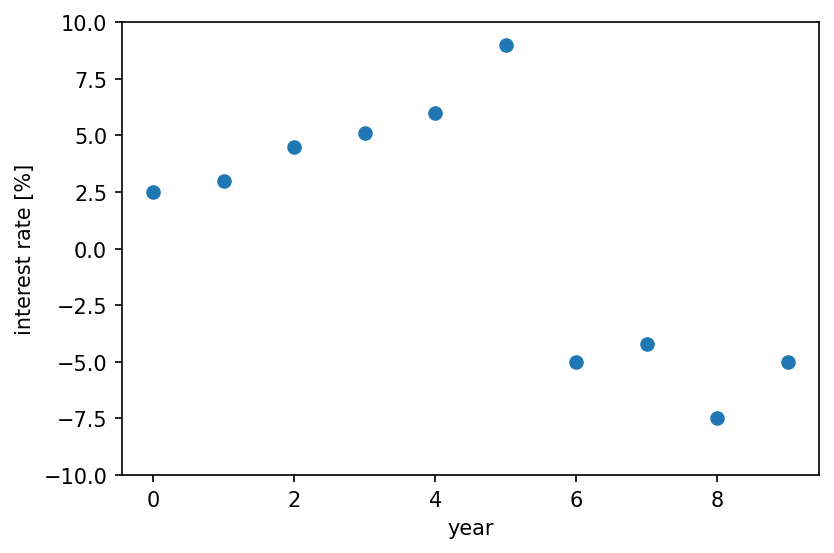

In [10]:
fig, ax = pyplot.subplots(dpi=150)

ax.scatter(years, interest_rate)
ax.set(
    ylim=(-10, 10),
    ylabel="interest rate [%]",
    xlabel="year",
)
pyplot.show()

### What's the portfolio value over time?
Based on the interest rate from above and in combination with our initial portfolio value (100 €),
we can work out the portfolio value in two ways:
1. Assuming continuous interest & re-invest ($e^{cumsum}$ method).
2. Payout and re-investing only at the end of the year (`for` loop).

Note that for portfolio/bank account this may depend on the contract, but for biomass growth the continuous model (1.) is definitely a good assumption.

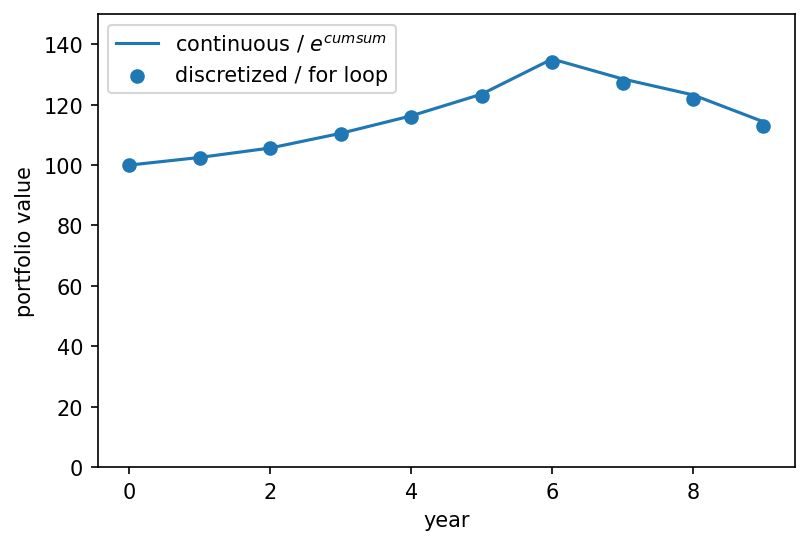

In [11]:
# calculate the portfolio value over time
values = [100]
for year, ir in zip(years, interest_rate[:-1]):
    delta = values[-1] * ir/100
    values.append(values[-1] + delta)
    
values_fast = numpy.hstack((
    [100],
    100 * numpy.exp(numpy.cumsum(interest_rate / 100) * 1))
)[:-1]

    
fig, ax = pyplot.subplots(dpi=150)

ax.scatter(years, values, label="discretized / for loop")
ax.plot(years, values_fast, label="continuous / $e^{cumsum}$")
ax.legend()
ax.set(
    ylim=(0, 150),
    ylabel="portfolio value",
    xlabel="year",
)
pyplot.show()

## Step 3 - Modeling the underlying causes
After establishing our toy dataset—this time with the _real_ mechanism—we can now build the corresponding PyMC3 model.
Here we'll implement the continuous model (1.) because it works without an expensive `for` loop.

Note how the PyMC3 model code reads almost exactly the same as the numpy implementation:
```python
values_fast = numpy.hstack((
    [100],
    100 * numpy.exp(numpy.cumsum(interest_rate / 100) * 1))
)[:-1]
```

In [12]:
with pymc3.Model() as pmodel:
    # model INTEREST RATE over time
    t_interest = pymc3.GaussianRandomWalk("interest", sd=3, shape=T + T_predict)
    
    # portfolio value is a deterministic result of the interest rate!
    t_values = pymc3.Deterministic(
        "values",
        tt.concatenate([
            [100.0],
            100 * tt.exp(tt.cumsum(t_interest / 100) * 1)
        ])[:-1]
    )
    
    # "measurements" are inaccurate with σ = 2 €
    pymc3.Normal("likelihood", mu=t_values[:T], sd=2, observed=values)

Again, we run MCMC sampling to infer the model parameters.
This time the interest rate.

In [13]:
with pmodel:
    idata_B = pymc3.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [interest]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 26 seconds.


Our visualization can now show the underlying interest rate in addition to the portfolio value.

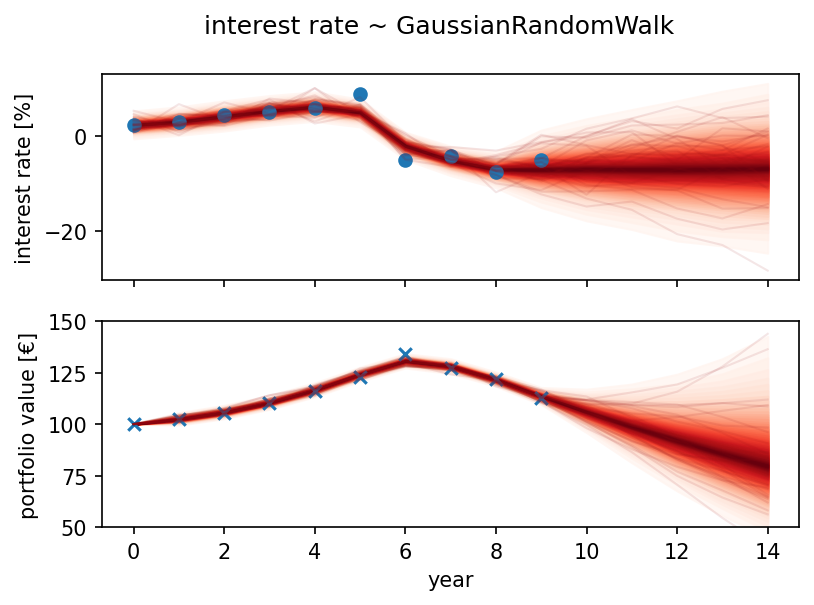

In [14]:
posterior = idata_B.posterior.stack(sample=("chain", "draw"))

fig, axs = pyplot.subplots(dpi=150, nrows=2, sharex=True)

ax = axs[0]
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=numpy.arange(T+T_predict),
    samples=posterior["interest"].values.T,
)
ax.scatter(years, interest_rate)
ax.set(
    ylabel="interest rate [%]"
)

ax = axs[1]
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=numpy.arange(T+T_predict),
    samples=posterior["values"].values.T,
)
ax.scatter(years, values, marker="x")

ax.set(
    ylim=(50, 150),
    ylabel="portfolio value [€]",
    xlabel="year",
)
fig.suptitle("interest rate ~ GaussianRandomWalk")
pyplot.show()

This time the model inferred the interest rate, albeit with a little more uncertainty than before.
We don't understand market dynamics, so we just assume that the interest rate may drift up/down with equal probability.

This time our predicted portfolio value looks much smoother and continues the downwards trend of the past 4 years.
There's also a slight chance that it might go up, but that really depends the future interest rate.

Notice that our inference of the interest rate is rather smooth around year 5.
The model sort of averages out the high/low interest rates at years 5/6, because it did not allow for such drastic changes.
That's the effect of `GaussianRandomWalk(..., sd=3, ...)` encoding a rather narrow prior belief in how fast the interest rate may drift.

Now obviously that interest rate drifted way more than 3 % points between years 5 and 6.
Can we choose a different model to allow for such outliers?

## Step 4 - StudentT random walk interest rate
When dealing with outliers, the Student-t distribution is often the first choice.
Through its fat tails the probability of extreme values does not got to 0 as fast as it does with the Normal distribution.
With a little helper function from `bletl.growth` we can construct a random walk with a Student-t distribution and use that instead of the `GuassianRandomWalk` for the interest rate:

In [15]:
student_t_params = dict(sigma=3, nu=5)

with pymc3.Model() as pmodel:
    # Use helper function to create one "by hand"
    # because StudentTRandomWalk wasn't implemented in PyMC3
    t_interest = bletl.growth._make_random_walk(
        "interest", **student_t_params, length=T + T_predict, student_t=True
    )
    
    # portfolio value is a deterministic result of the interest rate!
    t_values = pymc3.Deterministic(
        "values",
        tt.concatenate([
            [100.0],
            100 * tt.exp(tt.cumsum(t_interest / 100) * 1)
        ])[:-1]
    )
    
    # "measurements" are inaccurate with σ = 2 €
    pymc3.Normal("likelihood", mu=t_values[:T], sd=2, observed=values)

In [16]:
with pmodel:
    idata_C = pymc3.sample(
        return_inferencedata=True,
        # This 👇 line sets a tuning parameter to make it a little more robust.
        target_accept=0.9
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [interest__diff_]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 43 seconds.


On the first glance the result looks very similar, but this time the model is much closer to the real interest rates (🔵) around the time of the financial crisis.
Also the predictions become a little more uncertain further into the future.
That's because now we encoded a much stronger prior belief that there will be dramas (up and down) in the future.

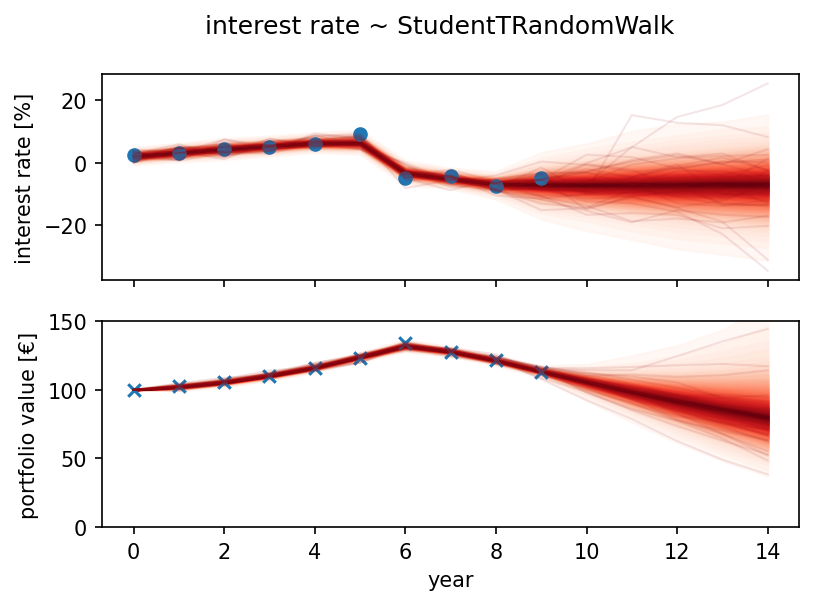

In [17]:
posterior = idata_C.posterior.stack(sample=("chain", "draw"))

fig, axs = pyplot.subplots(dpi=150, nrows=2, sharex=True)

ax = axs[0]
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=numpy.arange(T+T_predict),
    samples=posterior["interest"].values.T,
)
ax.scatter(years, interest_rate)
ax.set(
    ylabel="interest rate [%]"
)

ax = axs[1]
pymc3.gp.util.plot_gp_dist(
    ax=ax,
    x=numpy.arange(T+T_predict),
    samples=posterior["values"].values.T,
)
ax.scatter(years, values, marker="x")

ax.set(
    ylim=(0, 150),
    ylabel="portfolio value [€]",
    xlabel="year",
)
fig.suptitle("interest rate ~ StudentTRandomWalk")
pyplot.show()

## Step 5: Detecting switchpoints
We promised automated switchpoint detection, but before we do that with our toy example, let's revisit the intuition behind this approach.
This time with specific growth rate, because the next plot appears in the paper:

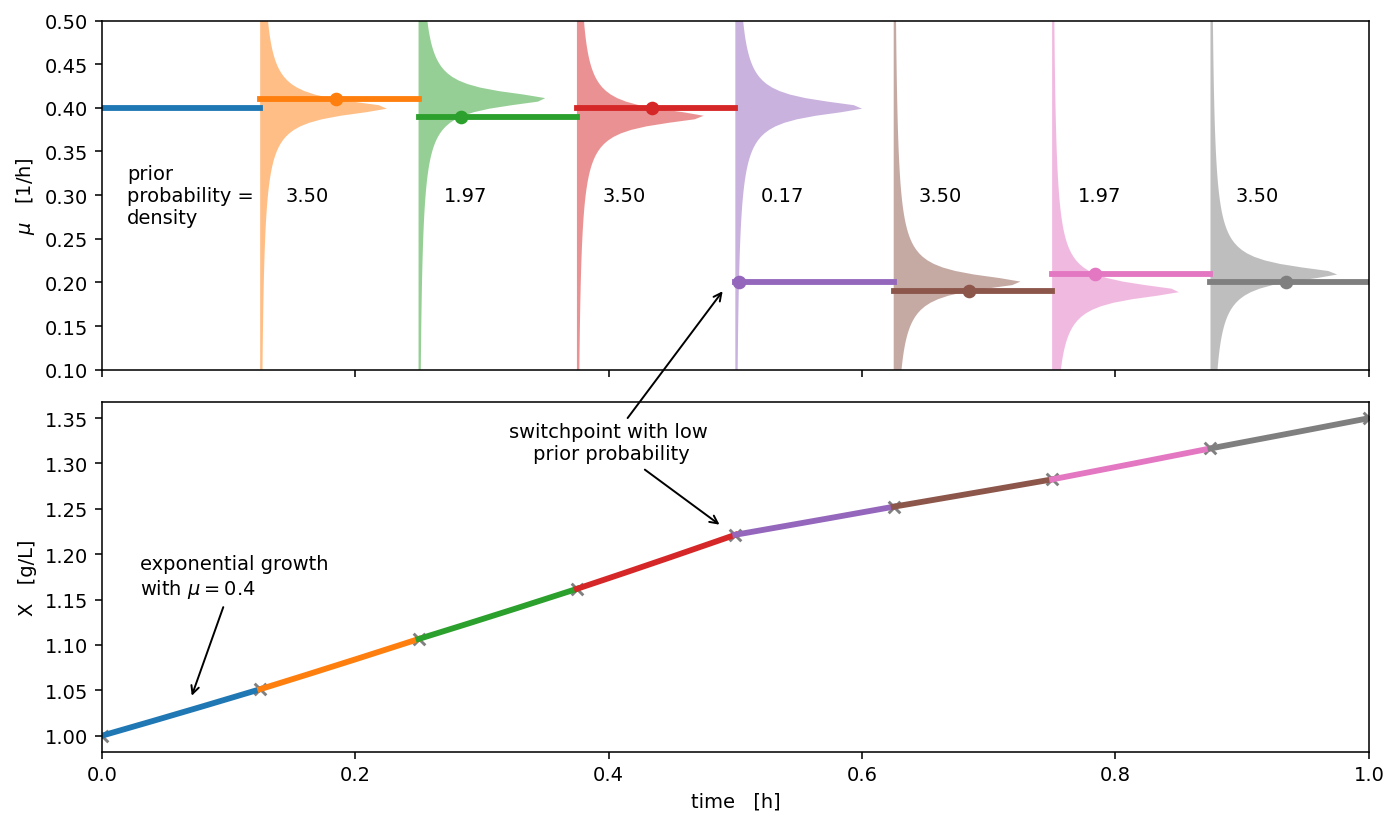

In [18]:
# First there was a vector of growth rates in each timestep
mut = numpy.array([0.4, 0.41, 0.39, 0.4, 0.2, 0.19, 0.21, 0.20])
# with potentially unevenly spaced time delta
dt = numpy.repeat(1/len(mut), len(mut))
# from which we can make a time axis.
t = numpy.cumsum(dt)

# Then there was an initial biomass concentration
X0 = 1
# from which we can simulate the biomass over time.
X = X0 * numpy.exp(numpy.cumsum(mut * dt))

t = [0, *t]
X = [X0, *X]

YMIN = numpy.round(mut.min() - 0.1, 1)
YMAX = numpy.round(mut.max() + 0.1, 1)

COLORS = cm.tab10

fig, axs = pyplot.subplots(figsize=(10, 6), nrows=2, sharex=True, dpi=140)

ax = axs[0]
ax.set(
    ylabel="$\mu$   [1/h]",
    ylim=(YMIN, YMAX),
)

for i in range(len(mut)):
    ax.plot([t[i], t[i+1]], [mut[i], mut[i]], color=COLORS(i), linewidth=3)
    if i+1 < len(mut):
        # draw the prior for mu2 (centered on mu1)
        ydense = numpy.linspace(YMIN, YMAX, 100)
        dist_kwargs = dict(loc=mut[i], scale=0.025, df=0.1)
        pdf = scipy.stats.t.pdf(**dist_kwargs, x=ydense)
        pp = scipy.stats.t.pdf(**dist_kwargs, x=mut[i+1])
        
        ax.fill_betweenx(
            y=ydense,
            x1=t[i+1] + pdf / pdf.max() / 10,
            x2=numpy.repeat(t[i+1], 100),
            alpha=0.5,
            facecolor=COLORS(i+1),
            edgecolor="none"
        )
        # prior probability density in the next iteration
        ax.scatter([t[i+1] + pp / pdf.max() / 10], [mut[i+1]], marker="o", color=COLORS(i+1))
        ax.text(t[i+1] + 0.02, 0.3, f"{numpy.round(pp, 2):.2f}", va="center")
ax.text(0.02, 0.3, "prior\nprobability =\ndensity", va="center", ha="left")

ax = axs[1]
ax.set(
    ylabel="X   [g/L]",
    xlabel="time   [h]",
    xlim=(0, 1)
)
ax.scatter(t, X, marker="x", color="gray")
for i in range(len(mut)):
    t_dense = numpy.linspace(t[i], t[i+1], 300)
    x = X[i] * numpy.exp(mut[i] * (t_dense - t[i]))
    ax.plot(t_dense, x, linewidth=3)
ax.annotate(
    "exponential growth\nwith $\mu=0.4$",
    xy=(0.07, 1.04),
    xytext=(0.03, 1.15),
    va="bottom",
    arrowprops=dict(arrowstyle='->')
)
ax.annotate(
    "switchpoint with low\n prior probability",
    xy=(0.49, 1.23),
    xytext=(0.4, 1.3),
    va="bottom", ha="center",
    arrowprops=dict(arrowstyle='->')
)

con = patches.ConnectionPatch(
    xyA=(0.415, 1.35), coordsA="data",
    xyB=(0.49, 0.19), coordsB="data",
    axesA=axs[1], axesB=axs[0],
    arrowstyle="->",
)
fig.tight_layout()
ax.add_artist(con)
fig.savefig(DP_RESULTS / "fig_mut_switchpoints.pdf", bbox_inches="tight")
fig.savefig(DP_RESULTS / "fig_mut_switchpoints.png", bbox_inches="tight")
pyplot.show()

The plot above shows not only the growth rates (horizontal lines) but also the prior probability density in a corresponding Student-t random walk.
For example, the orange density is centered on the growth rate in the first interval ($0.4\ 1/h$) and thereby we can calculate the prior probability of the growth rate in the second interval ($0.41\ 1/h$).
In math notation:

$$f_{prior}(\mu_{t+1}=0.41 \mid \mu_{t}=0.4)=3.5$$

We can also extract that prior probability of the changes from out interest rate model:

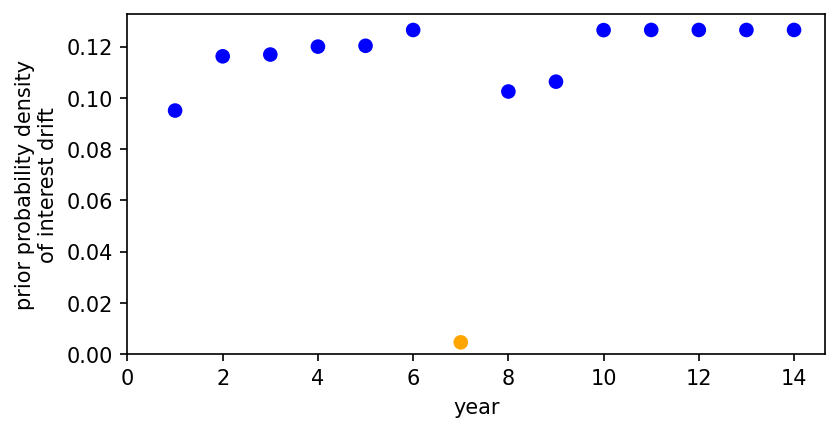

In [19]:
interest_diff = idata_C.posterior.interest__diff_.stack(sample=("chain", "draw"))
interest_diff = numpy.median(interest_diff, axis=1)
assert interest_diff.shape == (T+T_predict,)

p_interest_diff = scipy.stats.t.pdf(
    loc=0,
    scale=student_t_params["sigma"],
    df=student_t_params["nu"],
    x=interest_diff
)
# Likewise we can evaluate the cumulative density function:
cdf_interest_diff = scipy.stats.t.cdf(
    loc=0,
    scale=student_t_params["sigma"],
    df=student_t_params["nu"],
    x=interest_diff
)
# With an arbitrary threshold (here 2 %) we can filter for all timesteps
# where the delta is outside of the [2, 98] percentiles and consider those
# as significant switchpoints.
significance_mask = numpy.logical_or(
    cdf_interest_diff < 0.02,
    cdf_interest_diff > 0.98,
)

fig, ax = pyplot.subplots(dpi=150, figsize=(6, 3))
ax.scatter(
    1 + numpy.arange(len(p_interest_diff[:-1])),
    p_interest_diff[:-1],
    color=[
        ("orange" if sig else "blue")
        for sig in significance_mask[:-1]
    ]
)
ax.set(
    xlim=(0, None),
    xlabel="year",
    ylabel="prior probability density\nof interest drift",
    ylim=(0, None),
)
pyplot.show()

Note that the prior probability of the interest rate in year 7 (given the interest rate in year 6) is _really really_ low.
In fact, it is well below our arbitrarily chosen 2nd percentile by which we classify it as a switchpoint.

In [20]:
%load_ext watermark
%watermark

Last updated: 2021-07-30T19:56:52.083950+02:00

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.25.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 10, GenuineIntel
CPU cores   : 6
Architecture: 64bit

